In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def FPL_hider(R, eta):
    # R: the rewards that the seeker has got for each site
    num_of_sites = 5
    sites = np.zeros(num_of_sites)
    Z = np.random.exponential(scale=eta, size=num_of_sites)
    flags = np.argsort(R + Z)[0:2]
    sites[flags] = 1
    return sites

def play_fpl(opponent_policy, eta=1):
    all_rewards = []   # reward: 100 * 500
    for _ in range(100):
        rewards_list = []
        R = np.zeros(5)  # reset rewards of the seeker
        for i in range(500):
            sites_reward = opponent_policy(R, eta)
            Z = np.random.exponential(scale=eta, size=5)
            choices_index = np.argsort(R + Z)[-2:]
            rewards = sites_reward[choices_index]
            R[choices_index] += rewards
            rewards_list.append(sum(R) / (i + 1))
        all_rewards.append(rewards_list)
    all_rewards = np.asarray(all_rewards)
    average_rewards = np.average(all_rewards, axis=0)  # compute the average reward for every round
    plt.plot(average_rewards, label=('eta: '+str(eta)))
    plt.xlabel('the number of rounds')
    plt.ylabel('the average reward')
    plt.title('Seeker and hider: FPL')
    plt.legend()

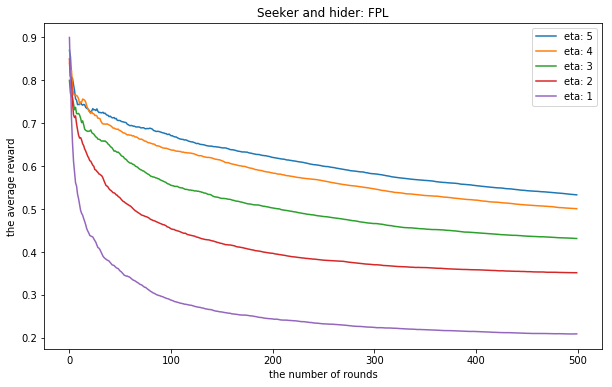

In [3]:
plt.figure(figsize=[10,6])
play_fpl(FPL_hider, eta=5)
play_fpl(FPL_hider, eta=4)
play_fpl(FPL_hider, eta=3)
play_fpl(FPL_hider, eta=2)
play_fpl(FPL_hider, eta=1)

In [4]:
def exp3_hider(gamma, weights, num_of_sites):
    # weights: The weights that the seeker has gained for each site.
    sites = np.zeros(num_of_sites)
    p = weights / sum(weights)
    if np.random.uniform() < gamma:
        flags = np.random.choice(num_of_sites, size=2, replace=False)
    else:
        flags = np.argsort(p)[0:2]
    sites[flags] = 1
    return sites


def play_exp3(opponent_policy, gamma=0.3):
    num_of_sites = 5
    num_of_rounds = 500
    num_of_times = 100
    all_rewards = []   # reward: 100 * 500
    for _ in range(num_of_times):
        rewards_list = []
        w = np.ones(num_of_sites)  # initialize the weights
        R = np.zeros(num_of_sites)
        for i in range(num_of_rounds):
            x = np.zeros(num_of_sites)
            sites_reward = opponent_policy(gamma, w, num_of_sites)
            p = (1 - gamma) * (w / sum(w)) + np.ones(num_of_sites) * gamma / num_of_sites
            # draw a uniform sample of size 2 without replacement
            choices_index = np.random.choice(num_of_sites, size=2, p=p, replace=False)
            x[choices_index] = sites_reward[choices_index] / p[choices_index]
            w = w * np.exp(gamma * x / num_of_sites)
            R[choices_index] += sites_reward[choices_index]
            rewards_list.append(sum(R) / (i + 1))
        all_rewards.append(rewards_list)  # add the average reward for the current episode
    all_rewards = np.asarray(all_rewards)
    # print(all_rewards)
    average_rewards = np.average(all_rewards, axis=0)  # compute the average reward for every round
    plt.plot(average_rewards, label=('gamma: '+str(gamma)))
    plt.xlabel('the number of rounds')
    plt.ylabel('the average reward')
    plt.title('Seeker and hider: Exp3')
    plt.legend()

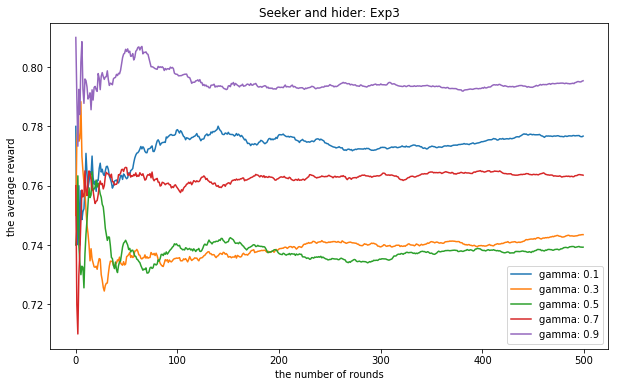

In [5]:
plt.figure(figsize=[10,6])
for gamma in [0.1, 0.3, 0.5, 0.7, 0.9]:
    play_exp3(exp3_hider, gamma)

### Part2

In [13]:
# decoupling version

def play(game, *args):
    all_rewards_t = []   # reward: 100 * 500
    all_rewards_f = []
    total_diff = []  # difference between the true reward and fake reward
    for _ in range(100):
        rewards_list_t, rewards_list_f, diff = game(*args)
        total_diff.append(diff)
        all_rewards_t.append(rewards_list_t)
        all_rewards_f.append(rewards_list_f)
    all_rewards_t = np.asarray(all_rewards_t)
    all_rewards_f = np.asarray(all_rewards_f)
    total_diff = np.asarray(total_diff)
    total_diff = np.average(total_diff, axis=0)
    average_rewards_t = np.average(all_rewards_t, axis=0)  # compute the average reward for every round
    average_rewards_f = np.average(all_rewards_f, axis=0)
    plt.figure(figsize=[8, 12])
    plt.subplot(211)
    plt.plot(average_rewards_t, label='true')
    plt.plot(average_rewards_f, label='fake')
    plt.title('Average reward of the seeker')
    plt.xlabel('the number of rounds')
    plt.ylabel('the average reward')
    plt.legend()
    plt.subplot(212)
    plt.plot(total_diff, label='fake reward - true reward')
    plt.title('The difference between the true and fake total reward')
    plt.xlabel('the number of rounds')
    plt.ylabel('total reward difference')
    plt.legend()
    
def fpl_vs_fpl(MAX_N_FAKE, eta):
    rewards_list_t = []
    rewards_list_f = []
    diff = []  # total fake reward - total true reward
    # reset rewards of the seeker
    R_t = np.zeros(5)  # true rewards
    R_f = np.zeros(5)  # fake rewards
    fake_timings = np.random.choice(500, size=MAX_N_FAKE, replace=False)  # assign the fake timings
    fake_timings = sorted(fake_timings, reverse=True)  # descending order
    for i in range(500):
        fake = False
        if len(fake_timings) > 0 and fake_timings[-1] == i:
            fake = True
            fake_timings.pop()
        fake_sites, true_sites = FPL_hider(R_t, R_f, fake, eta)
        Z = np.random.exponential(scale=eta, size=5)
        # the seeker chooses 2 sites based on the fake rewards
        choices_index = np.argsort(R_f + Z)[-2:]
        f_rewards = fake_sites[choices_index]
        t_rewards = true_sites[choices_index]
        R_t[choices_index] += t_rewards
        R_f[choices_index] += f_rewards
        rewards_list_t.append(sum(R_t) / (i + 1))
        rewards_list_f.append(sum(R_f) / (i + 1))
        diff.append(sum(R_f) - sum(R_t))
    return rewards_list_t, rewards_list_f, diff

def exp_vs_exp3(MAX_N_FAKE, gamma):
    num_of_sites = 5
    rewards_list_t = []
    rewards_list_f = []
    diff = []  # total fake reward - total true reward
    # reset rewards of the seeker
    R_t = np.zeros(5)  # true rewards
    R_f = np.zeros(5)  # fake rewards
    w_f = np.ones(5)  # initialize the fake weights
    w_t = np.ones(5)  # initialize the true weights
    fake_timings = np.random.choice(500, size=MAX_N_FAKE, replace=False)  # assign the fake timings
    fake_timings = sorted(fake_timings, reverse=True)  # descending order
    for i in range(500):
        fake = False
        if len(fake_timings) > 0 and fake_timings[-1] == i:
            fake = True
            fake_timings.pop()
        fake_sites, true_sites = Exp3_hider(w_t, w_f, fake, gamma)
        p_f = (1 - gamma) * (w_f / sum(w_f)) + np.ones(num_of_sites) * gamma / num_of_sites
        p_t = (1 - gamma) * (w_t / sum(w_t)) + np.ones(num_of_sites) * gamma / num_of_sites
        # draw a uniform sample of size 2 without replacement
        choices_index = np.random.choice(num_of_sites, size=2, p=p_f, replace=False)
        # update the fake weights
        x_f = np.zeros(num_of_sites)
        x_f[choices_index] = fake_sites[choices_index] / p_f[choices_index]
        w_f = w_f * np.exp(gamma * x_f / num_of_sites)
        # update the true weights
        x_t = np.zeros(num_of_sites)
        x_t[choices_index] = true_sites[choices_index] / p_t[choices_index]
        w_t = w_t * np.exp(gamma * x_t / num_of_sites)
        # accumulate rewards
        R_t[choices_index] += true_sites[choices_index]
        R_f[choices_index] += fake_sites[choices_index]
        # compute the average reward for the current step
        rewards_list_t.append(sum(R_t) / (i + 1))
        rewards_list_f.append(sum(R_f) / (i + 1))
        diff.append(sum(R_f) - sum(R_t))
    return rewards_list_t, rewards_list_f, diff

def FPL_hider(R_t, R_f, fake, eta):
    '''
    :param R_t: the true rewards that the seeker has got for each site
    :param R_f: the fake rewards that the seeker has got for each site
    :param fake: a boolean value which signifies whether to fake or not
    '''
    num_of_sites = 5
    true_sites = np.zeros(num_of_sites)
    Z = np.random.exponential(scale=eta, size=num_of_sites)
    # assign true flags
    t_flags = np.argsort(R_t + Z)[0:2]
    true_sites[t_flags] = 1
    # assign fake flags
    if fake:
        fake_sites = np.zeros(num_of_sites)
        # Give the seeker what she wants so that she tries to maximise the fake rewards.
        f_flags = np.argsort(R_f + Z)[-2:]
        fake_sites[f_flags] = 1
    else:
        fake_sites = true_sites
    return fake_sites, true_sites

def Exp3_hider(w_t, w_f, fake, gamma):
    '''
    :param w_t: True weights.
    :param w_f: Fake weigths.
    :param fake: a boolean value which signifies whether to fake or not.
    '''
    num_of_sites = 5
    # assign true sites, minimise the reward of the seeker
    p_t = w_t / sum(w_t)
    true_sites = np.zeros(num_of_sites)
    if np.random.uniform() < gamma:
        t_flags = np.random.choice(num_of_sites, size=2, replace=False)
    else:
        t_flags = np.argsort(p_t)[0:2]
    true_sites[t_flags] = 1
    # assign fake sites, maximise the reward of the seeker
    p_f = w_f / sum(w_f)
    if fake:
        fake_sites = np.zeros(num_of_sites)
        f_flags = np.argsort(p_f)[-2:]
        fake_sites[f_flags] = 1
    else:
        fake_sites = true_sites
    return fake_sites, true_sites

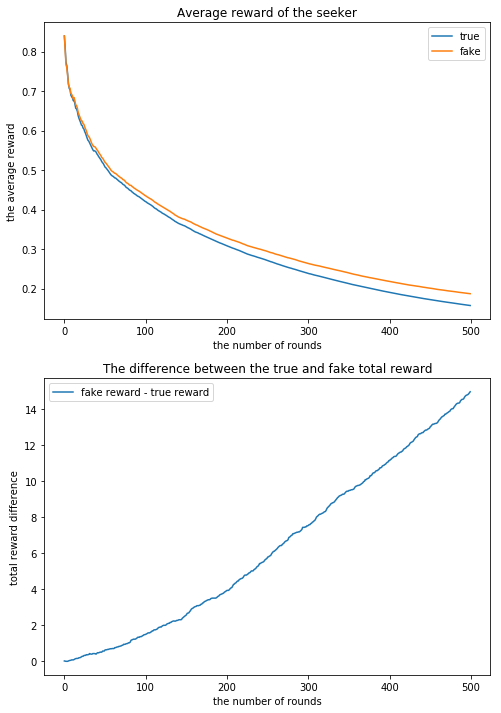

In [22]:
MAX_N_FAKE = 10
eta = 2
play(fpl_vs_fpl, MAX_N_FAKE, eta)

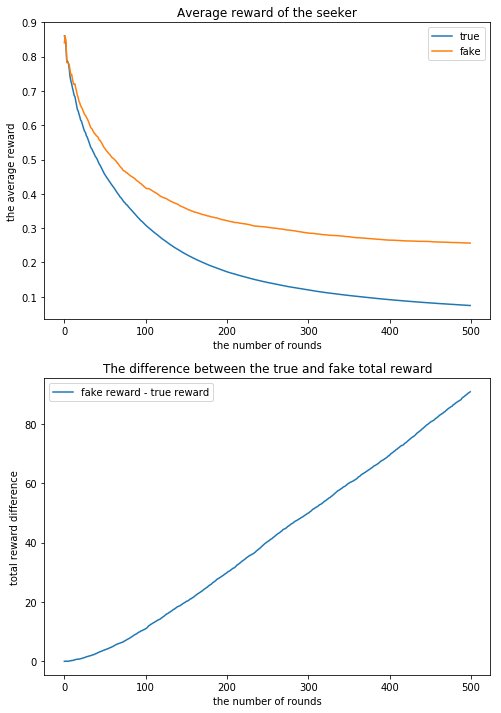

In [8]:
MAX_N_FAKE = 50
eta = 2
play(fpl_vs_fpl, MAX_N_FAKE, eta)

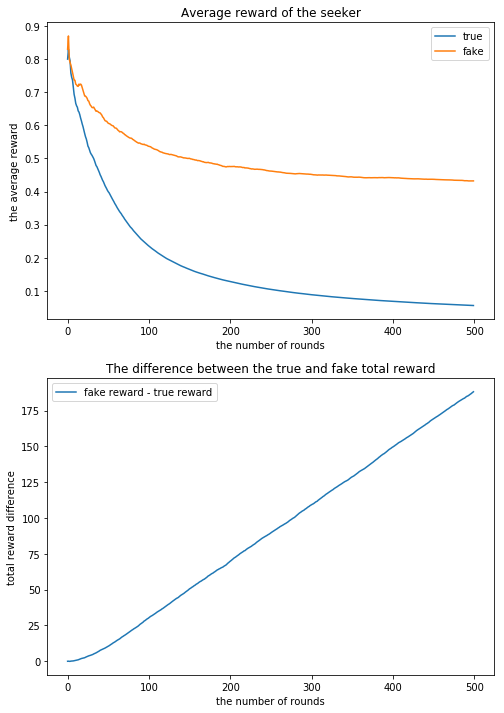

In [9]:
MAX_N_FAKE = 100
eta = 2
play(fpl_vs_fpl, MAX_N_FAKE, eta)

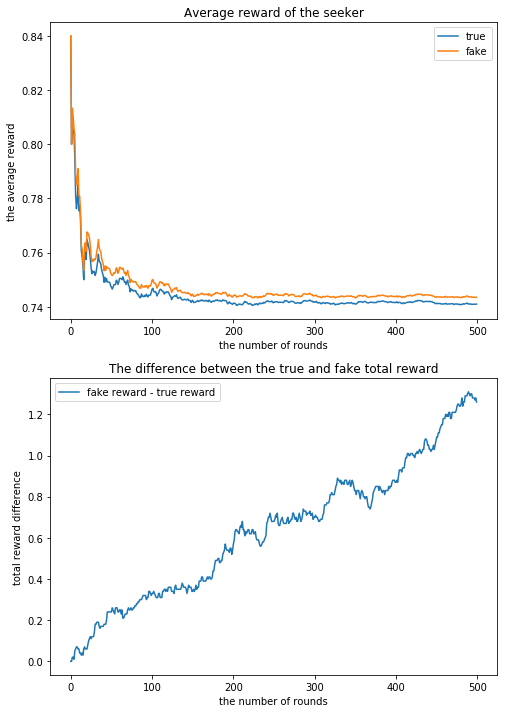

In [14]:
MAX_N_FAKE = 10
gamma = 0.3
play(exp_vs_exp3, MAX_N_FAKE, gamma)

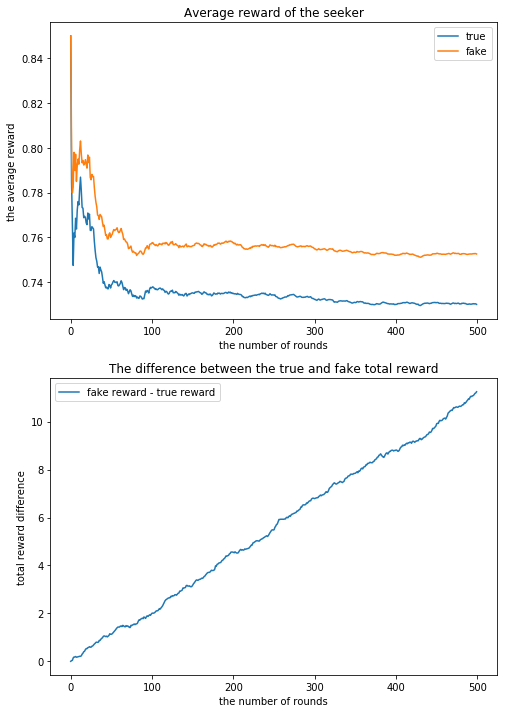

In [15]:
MAX_N_FAKE = 50
gamma = 0.3
play(exp_vs_exp3, MAX_N_FAKE, gamma)

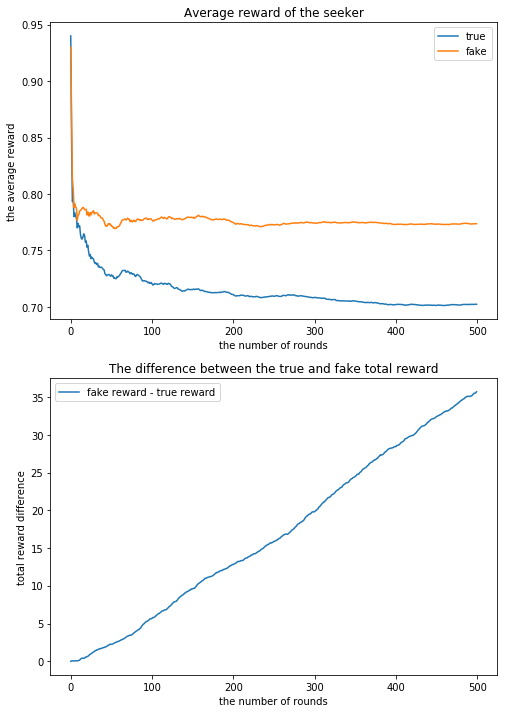

In [16]:
MAX_N_FAKE = 100
gamma = 0.3
play(exp_vs_exp3, MAX_N_FAKE, gamma)